In [1]:
import sys
sys.path.append("/global/homes/a/arosado/photometry/")

Used `/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELGzdone_full.dat.fits` for creating bricklists.

In [2]:
import os
import logging
import numpy as np
from matplotlib import pyplot as plt

from photometry import TargetSelection, utils, setup_logging

logger = logging.getLogger('DA02')
setup_logging()

plot_dir = 'plots'
run = 'south'
region = run[0].upper()
base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'
data_fn = os.path.join(base_dir, 'ELGzdone_full.dat.fits')
randoms_fn = os.path.join(base_dir, 'ELGzdone_0_full.ran.fits')
hp_fn = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits'
legacysim_fn = os.path.join(os.getenv('CSCRATCH'), 'legacysim', 'dr9', 'DA02', run, 'file0_rs0_skip0', 'merged', 'matched_input_concatenated.fits')
logger.info('Filename: {}'.format(legacysim_fn))

[ 000000.00 ]: 07-05 19:25  DA02            INFO     Filename: /global/cscratch1/sd/arosado/legacysim/dr9/DA02/south/file0_rs0_skip0/merged/matched_input_concatenated.fits


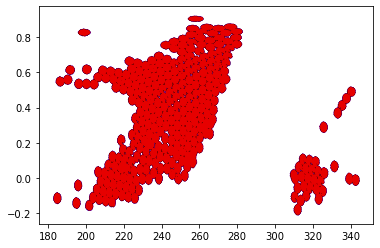

In [3]:
import fitsio as ft
d = ft.FITS(data_fn)[1]
r = ft.FITS(randoms_fn)[1]
#print(d['RA'][:])
kw = dict(s=0.2, alpha=0.05)#, color='b')
plt.scatter(d['RA'][:],np.sin(d['DEC'][:]*np.pi/180),color='b',**kw)
plt.scatter(r['RA'][:],np.sin(r['DEC'][:]*np.pi/180),color='r',**kw)
plt.show()

# Functions

In [4]:
def isELG_colors(gflux=None, rflux=None, zflux=None, w1flux=None,
                 w2flux=None, gfiberflux=None, south=True, primary=None,
                 gmarg=0., grmarg=0., rzmarg=0.):
    """
    Apply ELG selection with box enlarged by ``gmarg``, ``grmarg``, ``rzmarg``.

    SV3 selection from https://github.com/desihub/desitarget/blob/7786db0931d23ed20de7ef37a6f07a52072e11ab/py/desitarget/sv3/sv3_cuts.py#L526
    """
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    elg = primary.copy()

    # ADM work in magnitudes instead of fluxes. NOTE THIS IS ONLY OK AS
    # ADM the snr masking in ALL OF g, r AND z ENSURES positive fluxes.
    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))
    gfib = 22.5 - 2.5*np.log10(gfiberflux.clip(1e-16))

    # ADM cuts shared by the northern and southern selections.
    elg &= g > 20 - gmarg                # bright cut.
    elg &= r - z > 0.15 - rzmarg         # blue cut.
#    elg &= r - z < 1.6 + rzmarg         # red cut.

    # ADM cuts that are unique to the north or south. Identical for sv3
    # ADM but keep the north/south formalism in case we use it later.
    if south:
        elg &= gfib < 24.1 + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.
    else:
        elg &= gfib < 24. + gmarg  # faint cut.
        elg &= g - r < 0.5*(r - z) + 0.1 + grmarg  # remove stars, low-z galaxies.

    # ADM separate a low-priority and a regular sample.
    elgvlo = elg.copy()

    # ADM low-priority OII flux cut.
    elgvlo &= g - r < -1.2*(r - z) + 1.6 + grmarg
    elgvlo &= g - r >= -1.2*(r - z) + 1.3 - grmarg

    # ADM high-priority OII flux cut.
    elg &= g - r < -1.2*(r - z) + 1.3 + grmarg

    return elgvlo, elg


def mask_ts(self,key_flux='EFLUX',key_fiberflux='EFIBERFLUX',region=region,gmarg=0.,grmarg=0.,rzmarg=0.,gcut=-np.inf):
    mask = isELG_colors(gflux=self['{}_G'.format(key_flux)],rflux=self['{}_R'.format(key_flux)],
                        zflux=self['{}_Z'.format(key_flux)],gfiberflux=self['{}_G'.format(key_fiberflux)],south=region=='S',
                        gmarg=gmarg,grmarg=grmarg,rzmarg=rzmarg)
    mask = mask[0] | mask[1]
    mask &= self['{}_G'.format(key_flux)] > gcut
    return mask

TargetSelection.mask_ts = mask_ts

# Code

In [5]:
# legacysim
legacysim = TargetSelection.load_objects(legacysim_fn, radecbox=None, tracer='ELG', region=None)
legacysim.set_upper_case()
legacysim['RA'] = legacysim['INPUT_RA']
legacysim['DEC'] = legacysim['INPUT_DEC']
#legacysim['MATCHED'] = legacysim['DISTANCE'] < 0.15/3600.
logger.info('Found {:d}/{:d} matches.'.format(legacysim['MATCHED'].sum(),legacysim.size))
for b in legacysim.bands:
    legacysim['INPUT_EFLUX_{}'.format(b)] = utils.mag_to_flux(legacysim['INPUT_{}'.format(b)])
legacysim['INPUT_EFIBERFLUX_G'] = utils.mag_to_flux(legacysim['INPUT_GFIBER'])
legacysim.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
legacysim['EFIBERFLUX_G'] = legacysim.estimated_flux('G',key_transmission='MW_TRANSMISSION',key_flux='FIBERFLUX')
mask_tsin = legacysim.mask_ts(key_flux='INPUT_EFLUX',key_fiberflux='INPUT_EFIBERFLUX',region=region)#legacysim.trues() #
#mask_tsin &= np.all([legacysim['INPUT_NOBS_{}'.format(b)] for b in ['G', 'R', 'Z']], axis=0)
mask_tsout = legacysim.mask_ts(key_flux='EFLUX',key_fiberflux='EFIBERFLUX',region=region) & legacysim['MATCHED']
#mask_tsout &= np.all([legacysim['NOBS_{}'.format(b)] for b in ['G', 'R', 'Z']], axis=0)
logger.info('Selecting {:d} (output)/{:d} (input) injected sources.'.format(mask_tsout.sum(),mask_tsin.sum()))
legacysim_data = legacysim[mask_tsout]
legacysim_randoms = legacysim[mask_tsin]

[ 000011.22 ]: 07-05 19:25  Catalogue       INFO     Loading catalogue /global/cscratch1/sd/arosado/legacysim/dr9/DA02/south/file0_rs0_skip0/merged/matched_input_concatenated.fits.
[ 000093.33 ]: 07-05 19:26  TargetSelection INFO     Selecting 15861514/15861514 targets.
[ 000163.07 ]: 07-05 19:28  DA02            INFO     Found 12354850/15861514 matches.
[ 000173.27 ]: 07-05 19:28  DA02            INFO     Selecting 626263 (output)/580573 (input) injected sources.


[ 000338.12 ]: 07-05 19:31  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000338.34 ]: 07-05 19:31  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000338.39 ]: 07-05 19:31  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000338.40 ]: 07-05 19:31  HealpixDensity  INFO     Found 37890 bricks with randoms.


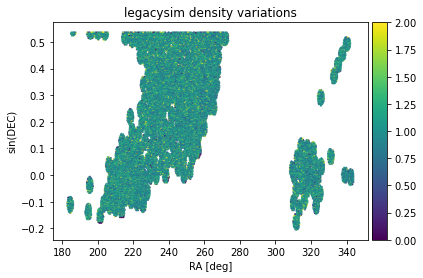

In [6]:
from photometry import Catalogue, HealpixDensity

# Density maps
map = Catalogue.load(hp_fn)
legacysim_dens = HealpixDensity(map=map)
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)
filename = os.path.join(plot_dir,'footprint_{}.png'.format(run))
legacysim_dens.plot_density_map(title='legacysim density variations',vmin=0,vmax=2)

In [7]:
spectro = True

def mask_data_zok(data, dchi2=0.9, tsnrcut=80):
    mask = data['o2c'] > dchi2
    mask &= data['ZWARN']*0 == 0
    mask &= data['ZWARN'] != 999999
    mask &= data['LOCATION_ASSIGNED'] == 1
    mask &= data['TSNR2_ELG'] > tsnrcut
    return mask

def mask_randoms_zok(randoms, tsnrcut=80):
    mask = randoms['TSNR2_ELG'] > tsnrcut
    return mask

# ELG targets, TS applied already
bricknames = np.unique(legacysim['BRICKNAME'])
logger.info('Found {:d} bricknames'.format(bricknames.size))
data = TargetSelection.load_objects(data_fn,region=region)

mask = np.in1d(data['BRICKNAME'],bricknames)
#mask[:] = True # do not cut data on the same bricks as legacysim
data.set_estimated_flux(key='EFLUX',key_transmission='MW_TRANSMISSION',key_flux='FLUX')
data['EFIBERFLUX_G'] = data.estimated_flux('G',key_transmission='MW_TRANSMISSION',key_flux='FIBERFLUX')
data.set_mag_from_flux(key_flux='EFLUX')

mask &= data.mask_ts(key_flux='EFLUX',key_fiberflux='EFIBERFLUX',region=region)
#mask &= data.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
if spectro: mask &= mask_data_zok(data)
data['WEIGHT'] = data.ones()
nreal = 128
#nassign = nreal*data['PROB_OBS'] + 1. #assignment in actual observation counts
#if spectro: data['WEIGHT'] *= (nreal+1)/nassign
if spectro: data['WEIGHT'] *= 1/data['FRACZ_TILELOCID']
logger.info('Selecting {:d}/{:d} targets.'.format(mask.sum(), mask.size))
data = data[mask]

randoms = TargetSelection.load_objects(randoms_fn,region=region)
from desiutil.brick import Bricks
randoms['BRICKNAME'] = Bricks().brickname(randoms['RA'], randoms['DEC'])

mask = np.in1d(randoms['BRICKNAME'],bricknames)
#mask[:] = True
#mask &= randoms.mask_maskbit(key_nobs='NOBS',key_maskbits='MASKBITS')
if spectro: mask &= mask_randoms_zok(randoms)
randoms = randoms[mask]

def from_map(cat, fields):
    import healpy as hp
    map = Catalogue.load(hp_fn)
    theta,phi = utils.radec_to_thphi(cat['RA'],cat['DEC'])
    hppix = hp.ang2pix(map.header['HPXNSIDE'],theta,phi,nest=map.header['HPXNEST'],lonlat=False)
    for field in fields: cat[field] = map[field][hppix]

[ 000344.80 ]: 07-05 19:31  DA02            INFO     Found 29345 bricknames
[ 000344.81 ]: 07-05 19:31  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELGzdone_full.dat.fits.
[ 000354.04 ]: 07-05 19:31  TargetSelection INFO     Selecting 1366937/1986996 targets.
<ipython-input-7-f1bb1b9a7c97>:33: RuntimeWarning: divide by zero encountered in true_divide
  if spectro: data['WEIGHT'] *= 1/data['FRACZ_TILELOCID']
[ 000358.71 ]: 07-05 19:31  DA02            INFO     Selecting 193133/1366937 targets.
[ 000359.79 ]: 07-05 19:31  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELGzdone_0_full.ran.fits.
[ 000363.32 ]: 07-05 19:31  TargetSelection INFO     Selecting 1304145/1909025 targets.


[ 000378.94 ]: 07-05 19:31  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000379.00 ]: 07-05 19:31  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000379.05 ]: 07-05 19:31  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000379.05 ]: 07-05 19:31  HealpixDensity  INFO     Found 37890 bricks with randoms.


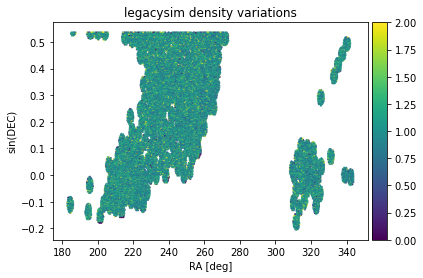

[ 000379.86 ]: 07-05 19:31  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000379.96 ]: 07-05 19:31  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000379.96 ]: 07-05 19:31  HealpixDensity  INFO     Found 33949 bricks with randoms.
[ 000379.99 ]: 07-05 19:31  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000380.04 ]: 07-05 19:31  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000380.04 ]: 07-05 19:31  HealpixDensity  INFO     Found 37890 bricks with randoms.
[ 000380.22 ]: 07-05 19:31  Properties      INFO     Calculating EBV statistics.
[ 000380.29 ]: 07-05 19:31  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0172.
[ 000380.29 ]: 07-05 19:31  Properties      INFO     Calculating EBV statistics.
[ 000380.35 ]: 07-05 19:31  HealpixDensity  INFO     Fraction of randoms not included in EBV plot: 0.0195.
[ 000380.36 ]: 07-05 19:31  Properties      INFO     Calculating GALDEPTH_G statistics.
[ 

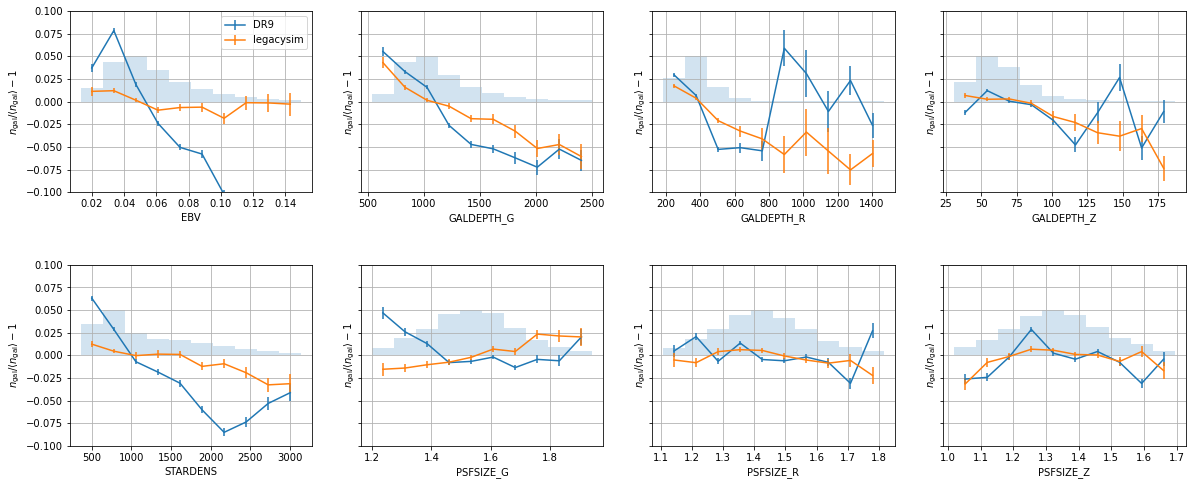

In [8]:
from photometry import Catalogue, HealpixDensity

# Density maps
map = Catalogue.load(hp_fn)
legacysim_dens = HealpixDensity(map=map)
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)
filename = os.path.join(plot_dir,'footprint_{}.png'.format(run))
legacysim_dens.plot_density_map(title='legacysim density variations',vmin=0,vmax=2)#,path=filename) ################################# to save

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()
dens.set_data(data=data,key_weight='WEIGHT')

legacysim_dens = HealpixDensity(map=map)
#legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
legacysim_dens.set_randoms(randoms=legacysim_randoms)
legacysim_dens.set_properties()
legacysim_dens.set_data(data=legacysim_data)

others = [legacysim_dens]
labels = ['DR9','legacysim']

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},ylim=(-0.1,0.1),xedges={'quantiles':[0.01,0.99]})
filename = os.path.join(plot_dir,'density_{}.png'.format(run))
#fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

# Test code

In [181]:
mask = dens.brickrandoms>0
brickrandoms = dens.brickrandoms[mask]
brickid = np.flatnonzero(mask)
print('Found {:d} bricks with randoms.'.format(len(brickid)))
print(brickid)
print(brickrandoms)

Found 33949 bricks with randoms.
[    0     1     2 ... 33946 33947 33948]
[ 9.  8. 59. ... 14. 45. 19.]


In [85]:
bricknames
for i, b in enumerate(randoms['BRICKNAME']): 
    if b == '1828m060':
        print(i,b)

64823 1828m060
64824 1828m060
64825 1828m060
64826 1828m060
64827 1828m060
64828 1828m060
64829 1828m060
64830 1828m060
64831 1828m060
64832 1828m060


In [135]:
d = data
r = randoms

27835 28706


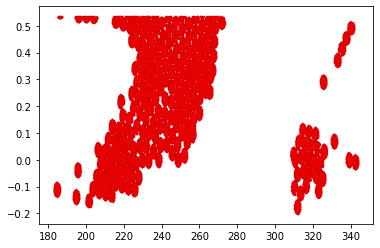

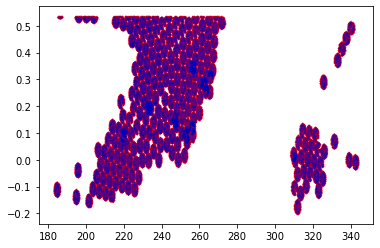

In [136]:
print(np.unique(data['BRICKNAME']).size, np.unique(randoms['BRICKNAME']).size)
kw = dict(s=0.2, alpha=0.05)#, color='b')
plt.scatter(d['RA'],np.sin(d['DEC']*np.pi/180),color='b',**kw)
plt.scatter(r['RA'],np.sin(r['DEC']*np.pi/180),color='r',**kw)
plt.show()

plt.scatter(r['RA'],np.sin(r['DEC']*np.pi/180),color='r',**kw)
plt.scatter(d['RA'],np.sin(d['DEC']*np.pi/180),color='b',**kw)
plt.show()

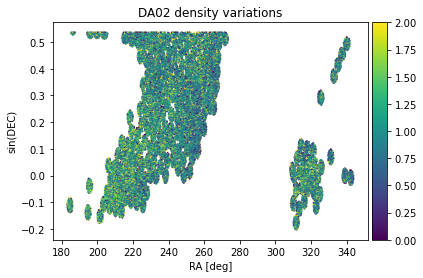

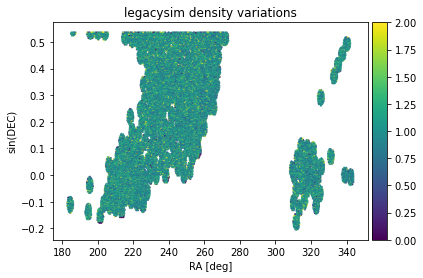

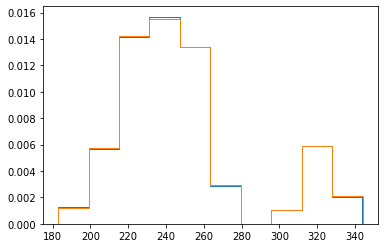

193133 1294624 15861514
33949 37890


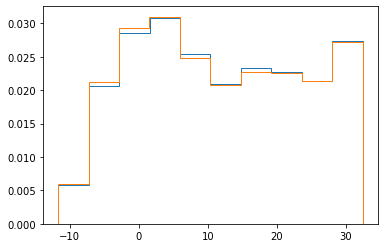

In [54]:
dens.plot_density_map(title='DA02 density variations',vmin=0,vmax=2)
legacysim_dens.plot_density_map(title='legacysim density variations',vmin=0,vmax=2)
#plt.scatter(data['RA']/randoms['RA'],np.sin(data['DEC']*np.pi/180)/np.sin(randoms['DEC']*np.pi/180),alpha=0.01)
#plt.show()
#plt.scatter(randoms['RA']/data['RA'],np.sin(randoms['DEC']*np.pi/180)/np.sin(data['DEC']*np.pi/180),alpha=0.2)
#plt.show()
kw = dict(histtype='step',density=True)
plt.hist(data['RA'],**kw)
plt.hist(randoms['RA'],**kw)
plt.show()
plt.hist(data['DEC'],**kw)
plt.hist(randoms['DEC'],**kw)
print(data['RA'].size, randoms['RA'].size, legacysim['RA'].size)
print(dens.properties['RA'].size, legacysim_dens.properties['RA'].size)

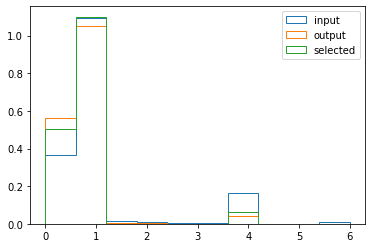

In [8]:
ax = plt.gca()
ax.hist(legacysim['INPUT_SERSIC'], histtype='step', label='input', density=True)
ax.hist(legacysim['SERSIC'], histtype='step', label='output', density=True)
ax.hist(legacysim_data['SERSIC'], histtype='step', label='selected', density=True)
#ax.hist(data['SERSIC'], histtype='step', label='in data', density=True)
ax.legend()

# Plot others

In [ ]:
from photometry import Catalogue, HealpixDensity

# Density maps
map = Catalogue.load(hp_fn)

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

others = []
labels = []
for sersic in [0, 1, 4]:
    legacysim_dens = HealpixDensity(map=map)
    #legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
    legacysim_dens.set_randoms(randoms=legacysim_randoms[legacysim_randoms['INPUT_SERSIC'] == sersic])
    legacysim_dens.set_properties()
    legacysim_dens.set_data(data=legacysim_data[legacysim_data['INPUT_SERSIC'] == sersic])
    others.append(legacysim_dens)
    labels.append('$n = {:d}$'.format(sersic))

dens, others = others[0], others[1:]

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},ylim=(-0.1,0.1),xedges={'quantiles':[0.01,0.99]})
filename = os.path.join(plot_dir,'density_{}.png'.format(run))
#fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

[ 000235.08 ]: 07-01 08:41  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/dark/pixweight-dark.fits.
[ 000235.15 ]: 07-01 08:41  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).
[ 000254.11 ]: 07-01 08:41  HealpixDensity  INFO     Inferring brickid from randoms.
[ 000254.11 ]: 07-01 08:41  HealpixDensity  INFO     Found 38359 bricks with randoms.
[ 000255.39 ]: 07-01 08:41  HealpixDensity  INFO     Found in header (nside,nest) = (256,True).


In [ ]:
from photometry import Catalogue, HealpixDensity

props = ['EBV'] + ['GALDEPTH_{}'.format(b) for b in data.bands] + ['STARDENS'] + ['PSFSIZE_{}'.format(b) for b in data.bands]

dens = HealpixDensity(map=map)
#dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
dens.set_randoms(randoms=randoms)
dens.set_properties()
dens.set_data(data=data,key_weight='WEIGHT')

others = []
labels = ['DR9']

for sersic in [None, 1]:
    legacysim_dens = HealpixDensity(map=map)
    #legacysim_dens = BinnedDensity(ref=randoms,fields=['EBV'],nbins=100,ranges=[0.01,0.14])
    if sersic is not None:
        legacysim_dens.set_randoms(randoms=legacysim_randoms[legacysim_randoms['INPUT_SERSIC'] == sersic])
    else:
        legacysim_dens.set_randoms(randoms=legacysim_randoms)
    legacysim_dens.set_properties()
    if sersic is not None:
        legacysim_dens.set_data(data=legacysim_data[legacysim_data['INPUT_SERSIC'] == sersic])
    else:
        legacysim_dens.set_data(data=legacysim_data)
    others.append(legacysim_dens)
    labels.append('legacysim' if sersic is None else 'legacysim $n = {:d}$'.format(sersic))

fig,lax = plt.subplots(ncols=4,nrows=2,sharex=False,sharey=True,figsize=(20,8))
fig.subplots_adjust(hspace=0.4,wspace=0.2)
lax = lax.flatten()
for iax,prop in enumerate(props):
    dens.plot_density_variations(ax=lax[iax],others=others,prop=prop,histos=[dens],var_kwargs={'labels':labels if iax==0 else None},leg_kwargs={},ylim=(-0.1,0.1),xedges={'quantiles':[0.01,0.99]})
filename = os.path.join(plot_dir,'density_{}.png'.format(run))
#fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

# dn/dz

In [ ]:
def plot_dndz_variations(ax, z, samples, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', labels=None):

    usamples = np.unique(samples)
    nsamples = len(usamples)
    if labels is None:
        labels = [None]*nsamples
    
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)*np.sqrt(nsamples)
    mid = (zbins[:-1] + zbins[1:])/2.
    ax.fill_between(mid, -perr, perr, color='gray')

    for isample, (sample, label) in enumerate(zip(usamples, labels)):
        mask = samples == sample
        dndzw_sample = np.histogram(z[mask], bins=zbins, weights=weights[mask] if weights is not None else None)[0]
        ratio = dndzw_sample.sum()/dndzw.sum()
        toplot =  1./ratio*dndzw_sample/dndzw - 1.
        ax.plot(mid,toplot, color='C{:d}'.format(isample), linestyle=linestyle, label=label)
    ax.set_xlabel('redshift')
    ax.set_ylabel('relative change in n(z)')
    ax.grid(True)
    ax.set_ylim(-0.3, 0.3)

In [36]:
def plot_dndz_variations_test(ax, z, samples, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', labels=None):

    usamples = np.unique(samples)
    nsamples = len(usamples)
    if labels is None:
        labels = [None]*nsamples
    
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)*np.sqrt(nsamples)
    mid = (zbins[:-1] + zbins[1:])/2.
    ax.fill_between(mid, -perr, perr, color='gray')
    
    dndz_list = []
    
    for isample, (sample, label) in enumerate(zip(usamples, labels)):
        print(isample,(sample,label), samples)
        mask = samples == sample
        dndzw_sample = np.histogram(z[mask], bins=zbins, weights=weights[mask] if weights is not None else None)[0]
        ratio = dndzw_sample.sum()/dndzw.sum()
        toplot =  1./ratio*dndzw_sample/dndzw - 1.
        #print(toplot)
        dndz_list.append(toplot)
        ax.plot(mid,toplot, color='C{:d}'.format(isample), linestyle=linestyle, label=label)
    
    ax.set_xlabel('redshift')
    ax.set_ylabel('relative change in n(z)')
    ax.grid(True)
    ax.set_ylim(-0.3, 0.3)
    #print(dndz_list)
    return mid, dndz_list

[   0.          243.14416504  312.57003784  375.06185913  469.41705322
 2489.85449219]
[3 3 3 ... 4 4 4]
bin means: [  0.                  nan  38.10280004  52.01834992  66.3724437
  79.50581897  93.75061561 107.237671   121.11114805 136.01355479
 150.61607143 165.04796531 179.28707176 193.45839159 207.42979308
 221.61392962 235.84190466]
bin edges [  0.        14.302571  28.605143  42.907715  57.210285  71.512856
  85.81543  100.118    114.42057  128.72314  143.02571  157.32828
 171.63086  185.93343  200.236    214.53856  228.84114  243.1437  ]
bin means: [245.14069159 249.28599287 253.34302103 257.44350028 261.49707178
 265.65728797 269.71535115 273.79271401 277.85867374 281.99015034
 286.06154317 290.13093675 294.24359763 298.29682821 302.4078099
 306.48024985 310.55073362]
bin edges [243.14417 247.228   251.31184 255.39568 259.47952 263.56335 267.6472
 271.73102 275.81485 279.8987  283.98254 288.06638 292.1502  296.23404
 300.31787 304.40173 308.48557 312.5694 ]
bin means: [314.400

<ipython-input-168-f1cf0f3a62c4>:19: RuntimeWarning: invalid value encountered in true_divide
  bin_means = (np.histogram(depth[mask], 17, weights=depth[mask])[0]/ np.histogram(depth[mask], bins)[0])
[ 021249.62 ]: 07-04 15:45  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_clustering.dat.fits.


2 (2, '313 < depth_r < 375') [3 3 3 ... 4 4 4]
3 (3, '375 < depth_r < 469') [3 3 3 ... 4 4 4]
4 (4, '469 < depth_r < 2490') [3 3 3 ... 4 4 4]
0 (0, None) [0 0 0 ... 1 1 2]
1 (1, None) [0 0 0 ... 1 1 2]
2 (2, None) [0 0 0 ... 1 1 2]
3 (3, None) [0 0 0 ... 1 1 2]
4 (4, None) [0 0 0 ... 1 1 2]
5 (5, None) [0 0 0 ... 1 1 2]


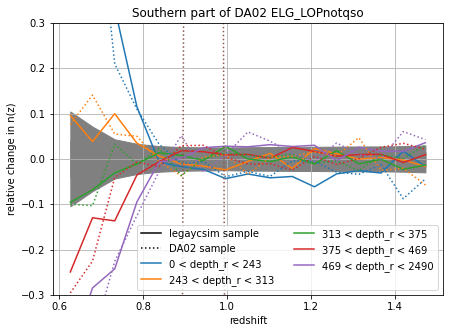

[   0.          702.94020996  904.27718506 1098.18322754 1382.03095703
 4752.38183594]
[1 1 1 ... 4 4 4]
bin means: [  0.          71.54093933 110.31462468 149.84910201 189.06432867
 227.35450372 271.00209782 309.87926875 352.37801535 393.44742867
 435.47579415 476.27236869 517.78546377 558.96231866 599.8461621
 641.16739246 682.4124407 ]
bin edges [  0.        41.349236  82.69847  124.04771  165.39694  206.74619
 248.09541  289.44464  330.79388  372.14313  413.49237  454.84158
 496.19083  537.54004  578.8893   620.2385   661.58777  702.937   ]
bin means: [709.02032086 720.57821458 732.66277348 744.46273999 756.29333333
 768.07677515 780.00161172 791.83092301 803.58630026 815.41583344
 827.22638995 839.22284088 851.02180107 862.90397621 874.68974475
 886.57745651 898.37906178]
bin edges [702.945   714.7881  726.6311  738.4742  750.31726 762.16034 774.00336
 785.84644 797.6895  809.53253 821.3756  833.2187  845.0617  856.9048
 868.74786 880.59094 892.43396 904.27704]
bin means: [ 909.92

[ 021250.26 ]: 07-04 15:45  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/ELG_LOPnotqsozdone_clustering.dat.fits.


2 (2, '904 < depth_g < 1098') [1 1 1 ... 4 4 4]
3 (3, '1098 < depth_g < 1382') [1 1 1 ... 4 4 4]
4 (4, '1382 < depth_g < 4752') [1 1 1 ... 4 4 4]
0 (0, None) [0 0 0 ... 1 1 3]
1 (1, None) [0 0 0 ... 1 1 3]
2 (2, None) [0 0 0 ... 1 1 3]
3 (3, None) [0 0 0 ... 1 1 3]
4 (4, None) [0 0 0 ... 1 1 3]
5 (5, None) [0 0 0 ... 1 1 3]


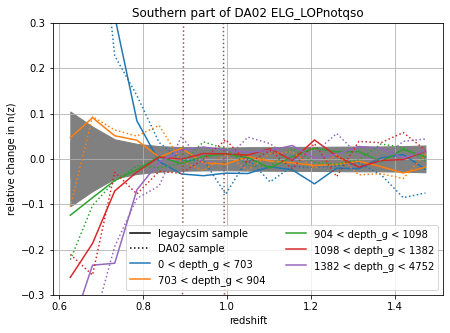

In [168]:
for prefix in ['ELG_LOPnotqso']:#,'ELG']:
    for column, name in [('GALDEPTH_R', 'depth_r'), ('GALDEPTH_G', 'depth_g'), ('EBV', 'ebv')][:-1]:
        z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
        depth = legacysim_data[column]
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        print(quantiles)
        labels = ['{:.0f} < {} < {:.0f}'.format(low, name, high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        #print(labels)
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        print(samples)
        # to get depth statistics
        #depth_list_mean = []
        #depth_list_median = []
        depth_list = [] 
        for isample, (sample, label) in enumerate(zip(np.unique(samples), labels)):
            mask = samples == sample
            #depth_bin = depth[mask]
            #depth_bin = np.histogram(depth[mask], bins=17)[0]
            bin_means = (np.histogram(depth[mask], 17, weights=depth[mask])[0]/ np.histogram(depth[mask], bins)[0])
            print('bin means:', bin_means)
            #print(depth_bin)
            print('bin edges',np.histogram(depth[mask], bins=18-1, weights=None)[1])
            #print(depth_bin.min(),depth_bin.max(),depth_bin.mean(),np.median(depth_bin))
            #depth_list.append(depth_bin)
            depth_list.append(bin_means)
            #depth_list_mean.append(depth_bin.mean())
            #depth_list_median.append(np.median(depth_bin))
        #
        
        ax = plt.gca()
        fig = plt.gcf()
        fig.set_size_inches(7, 5)
        ax.plot([], [], linestyle='-', color='k', label='legaycsim sample')
        ax.plot([], [], linestyle=':', color='k', label='DA02 sample')
        mid, l = plot_dndz_variations_test(ax, z, samples, linestyle='-', labels=labels)

        data_full = data
        data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format(prefix)))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        data_clustering = data_clustering[ind1]
        z = data_clustering['Z']
        weights = data_clustering['WEIGHT_COMP']
        depth = data_full[column][ind2]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        _,_ = plot_dndz_variations_test(ax, z, samples, weights=weights, linestyle=':')
        ax.set_title('Southern part of DA02 {}'.format(prefix))

        ax.legend(loc=4, ncol=2)
        filename = os.path.join(plot_dir, 'dndz_{}_{}_{}.png'.format(prefix, run, name))
        #fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

In [140]:
depth[samples==0].max(), depth.max()

(702.9351, 4769.097)

In [153]:
bins = np.histogram(depth[samples==0], bins=17)[1]

In [167]:
bin_means = (np.histogram(depth[samples==0], bins, weights=depth[samples==0])[0])#/ np.histogram(depth[samples==0], bins)[0])
bin_means

array([0.0000000e+00, 0.0000000e+00, 1.2099340e+03, 1.1058539e+04,
       5.0372832e+04, 1.0538063e+05, 1.7528706e+05, 2.3514236e+05,
       3.0358934e+05, 4.4328725e+05, 5.9808012e+05, 8.7490625e+05,
       1.4096372e+06, 1.8555861e+06, 2.2814480e+06, 2.5012688e+06,
       2.7794390e+06], dtype=float32)

[0.62647059 0.67941176 0.73235294 0.78529412 0.83823529 0.89117647
 0.94411765 0.99705882 1.05       1.10294118 1.15588235 1.20882353
 1.26176471 1.31470588 1.36764706 1.42058824 1.47352941]
[  0.          71.54093933 110.31462468 149.84910201 189.06432867
 227.35450372 271.00209782 309.87926875 352.37801535 393.44742867
 435.47579415 476.27236869 517.78546377 558.96231866 599.8461621
 641.16739246 682.4124407 ]
17 17


(-0.3, 0.3)

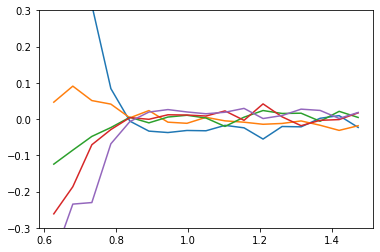

In [169]:
print(mid)
#print(depth_list_mean)
#print(depth_list_median)
print(depth_list[0])

print(len(l[0]),len(depth_list[0]))
for i in range(len(l)):
    plt.plot(mid,l[i])
plt.ylim(-0.3,0.3)

In [53]:
print('z','mean_depth_g','median_depth_g',[f'dndz_bin{i}' for i in range(len(l))])

z mean_depth_g median_depth_g ['dndz_bin0', 'dndz_bin1', 'dndz_bin2', 'dndz_bin3', 'dndz_bin4']


In [170]:
from astropy.table import Table, Column
#t = Table([mid,l[0],l[1],l[2],l[3],l[4],depth_list_mean,depth_list_median],
#          names=('z','mean_depth_g','median_depth_g','dndz_bin0','dndz_bin1','dndz_bin2','dndz_bin3','dndz_bin4'))
# now set depth value for each bin

#t = Table([mid,l[0],l[1],l[2],l[3],l[4]],
#          names=('z','dndz_bin0','dndz_bin1','dndz_bin2','dndz_bin3','dndz_bin4'))
d = depth_list
#t = Table([mid,d[0],l[0],d[1],l[1],d[2],l[2],d[3],l[3],d[4],l[4]],
#          names=('z','depth_g_bin0','dndz_bin0','depth_g_bin1','dndz_bin1','depth_g_bin2','dndz_bin2','depth_g_bin3','dndz_bin3','depth_g_bin4','dndz_bin4'))
#plt.plot(t['z'],t['dndz_bin0'])
#plt.ylim(-0.3,0.3)
t

z,depth_g_bin0,dndz_bin0,depth_g_bin1,dndz_bin1,depth_g_bin2,dndz_bin2,depth_g_bin3,dndz_bin3,depth_g_bin4,dndz_bin4
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.6264705882352941,0.0,0.7583085853804377,709.020320855615,0.04669390799087303,909.9222588925559,-0.12434042333693696,1106.5463626492942,-0.2614972808210202,1471.9732518307317,-0.38205047913966195
0.6794117647058824,71.54093933105469,0.43852073267674996,720.5782145782146,0.09089898082498982,921.4251648909183,-0.08564719130674636,1123.2435076278095,-0.18668009727708668,1669.0103926482873,-0.2346241021988591
0.7323529411764705,110.31462468327703,0.31463828311211595,732.6627734824807,0.05106999374230936,932.7120976116303,-0.04783580123718556,1139.8733661110446,-0.07084417416154754,1870.197129640612,-0.23035271006433944
0.7852941176470588,149.84910201149424,0.08411728579126732,744.4627399934917,0.04128813963265476,944.264027234901,-0.023375263679364044,1156.7186468646864,-0.02895394948833463,2064.644139974079,-0.06820583295190041
0.8382352941176471,189.0643286736021,-0.005669037485143802,756.2933333333333,0.003473560195653924,955.5303709235748,0.004975856871465512,1173.24870653351,0.004032465611684799,2263.3715059897318,-0.006901035089328711
0.8911764705882352,227.35450371665937,-0.03323790961537876,768.076775147929,0.023481775048515896,967.0633152173913,-0.010386215487696138,1189.9794207317073,-0.0006010783612645509,2462.8861376090927,0.019362804965588287
0.9441176470588235,271.0020978228001,-0.03713217038297778,780.0016117216118,-0.008537162523324593,978.3360359153043,0.005614137647995232,1206.715420908865,0.011853017781161324,2659.7433384379788,0.026207471326698872
0.9970588235294118,309.87926874536004,-0.03143707222118908,791.8309230114845,-0.011659816026439729,989.8058038784211,0.010543571487223513,1223.4696685428394,0.01118704886011379,2850.859010801592,0.019677010679887363
1.0499999999999998,352.3780153508772,-0.032269908324025987,803.5863002572086,0.004817142102840899,1001.3066601779756,0.002912967600223082,1239.926347971095,0.008418049004253358,3048.4225687103594,0.014645144748820949


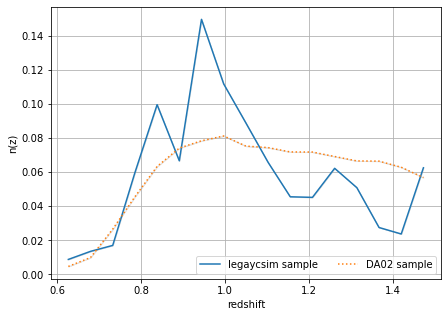

0.1331603536365823


In [11]:
def plot_dndz(ax, z, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', label=None):
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)
    mid = (zbins[:-1] + zbins[1:])/2.
    norm = dndzw.sum()
    dndzw, perr = dndzw/norm, perr/norm
    ax.fill_between(mid, dndzw-perr, dndzw+perr, color='gray', alpha=0.2)
    ax.plot(mid, dndzw, linestyle=linestyle, label=label)
    ax.set_xlabel('redshift')
    ax.set_ylabel('n(z)')
    ax.grid(True)

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(7, 5)
z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
plot_dndz(ax, z, linestyle='-', label='legaycsim sample')
z = data_clustering['Z']
weights = data_clustering['WEIGHT_COMP']
plot_dndz(ax, z, weights=weights, linestyle=':', label='DA02 sample')
ax.legend(loc=4, ncol=2)
plt.show()
print((z<0.8).sum()*1./z.size)

In [12]:
print(np.unique(legacysim_data['INPUT_HSC_DEMP_PHOTOZ_BEST']))

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

In [16]:
hsc_dir = '/global/cfs/cdirs/desi/target/analysis/truth/parent'
hsc_fn = os.path.join(hsc_dir,'hsc-pdr2-dud-cosmos-reduced.fits')
hsc = Catalogue.load_fits(hsc_fn)
#print(hsc.fields)
print(np.unique(hsc['mizuki_photoz_best']).size)

[ 000568.15 ]: 07-01 08:27  Catalogue       INFO     Loading catalogue /global/cfs/cdirs/desi/target/analysis/truth/parent/hsc-pdr2-dud-cosmos-reduced.fits.


642


# Test fits

y = 3.25443 * x + -0.01170 * x^2 + -155.02783


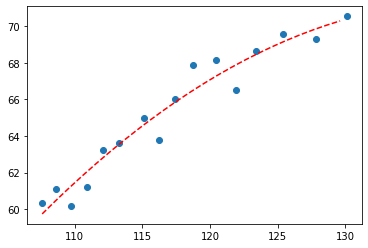

In [18]:
#https://machinelearningmastery.com/curve-fitting-with-python/
# fit a second degree polynomial to the economic data
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
 
# define the true objective function
def objective(x, a, b, c):
	return a * x + b * x**2 + c
 
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/longley.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
# choose the input and output variables
x, y = data[:, 4], data[:, -1]
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
# plot input vs output
pyplot.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red')
pyplot.show()

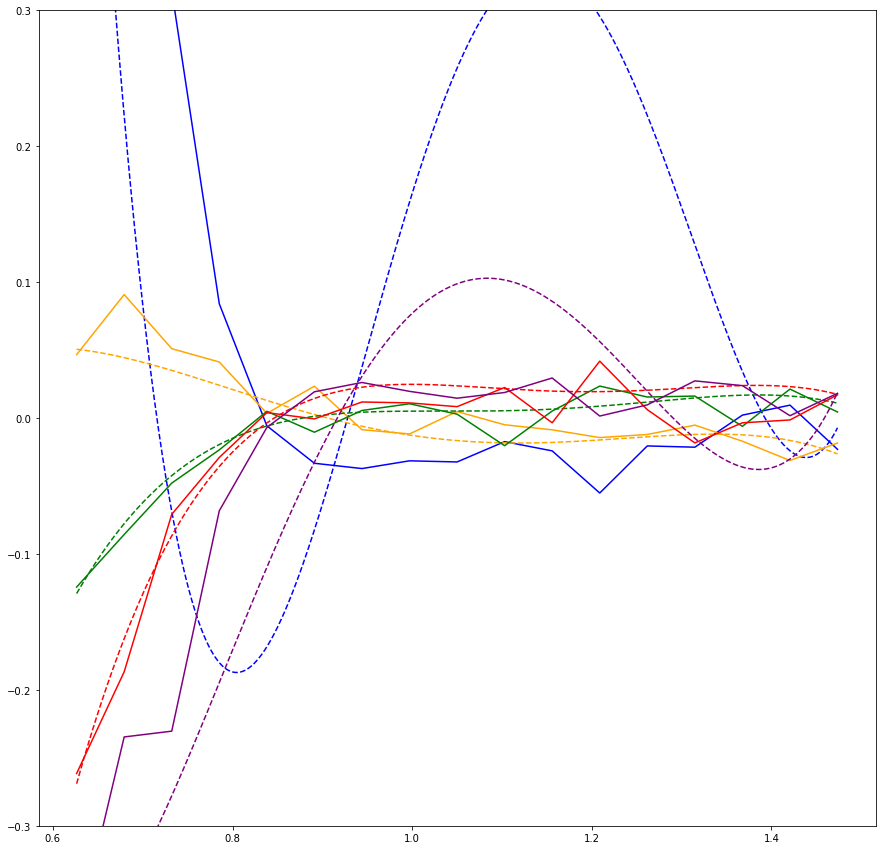

In [180]:
#https://machinelearningmastery.com/curve-fitting-with-python/
# fit a second degree polynomial to the economic data
from scipy.optimize import curve_fit
#plt.scatter(t['z'],t['dndz_bin0'])
#plt.ylim(-0.3,0.3)
fig = plt.figure(figsize=(15,15))
colors = ['b','orange','g','r','purple']

# define the true objective function
def objective(X, a, b, c, d, e, f, g, h, i):
    x,y = X
    #return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f
    return (a * x)+(b * y) + (c * x**2)+(d * y**2) + (e * x**3)+(f * y**3) + (g * x**4)+(h * y**4) + i # (d * x**4) + (e * x**5) + f

for ite, (dncol,depthcol) in enumerate(zip([f'dndz_bin{i}' for i in range(5)],[f'depth_g_bin{i}' for i in range(5)])):
    # choose the input and output variables
    x, y, z = t['z'], t[depthcol], t[dncol]
    # curve fit
    popt, _ = curve_fit(objective, (x,y),z)
    # summarize the parameter values
    a, b, c, d, e, f, g, h, i = popt
    #print('y = %.5f * x + %.5f * x^2 + %.5f * x^3 + %.5f * x^4 + %.5f * x^5 + %.5f' % (a, b, c, d, e, f))
    # plot input vs output
    plt.plot(x,z, color=colors[ite])
    #plt.show()
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.linspace(min(x), max(x), 1000)
    y_line = np.linspace(min(y), max(y), 1000)
    #print(x_line)
    # calculate the output for the range
    #y_line = objective(x_line, a, b, c, d, e, f)
    z_line = objective((x_line,y_line), a, b, c, d, e, f, g, h, i)
    # create a line plot for the mapping function
    plt.plot(x_line, z_line, '--', color=colors[ite])
plt.ylim(-0.3,0.3)
plt.show()

y = -102.94998 * x + 159.77361 * x^2 + -123.06065 * x^3 + 47.15115 * x^4 + -7.20206 * x^5 + 26.24090
y = 69.04170 * x + -138.02958 * x^2 + 134.11707 * x^3 + -63.61281 * x^4 + 11.81686 * x^5 + -13.34220
y = 8.26449 * x + -7.61083 * x^2 + 0.47098 * x^3 + 2.52275 * x^4 + -0.90880 * x^5 + -2.73521
y = 69.40631 * x + -124.22257 * x^2 + 111.59891 * x^3 + -50.22760 * x^4 + 9.03767 * x^5 + -15.57616
y = -46.67795 * x + 113.74559 * x^2 + -125.16128 * x^3 + 64.60351 * x^4 + -12.75168 * x^5 + 6.27532


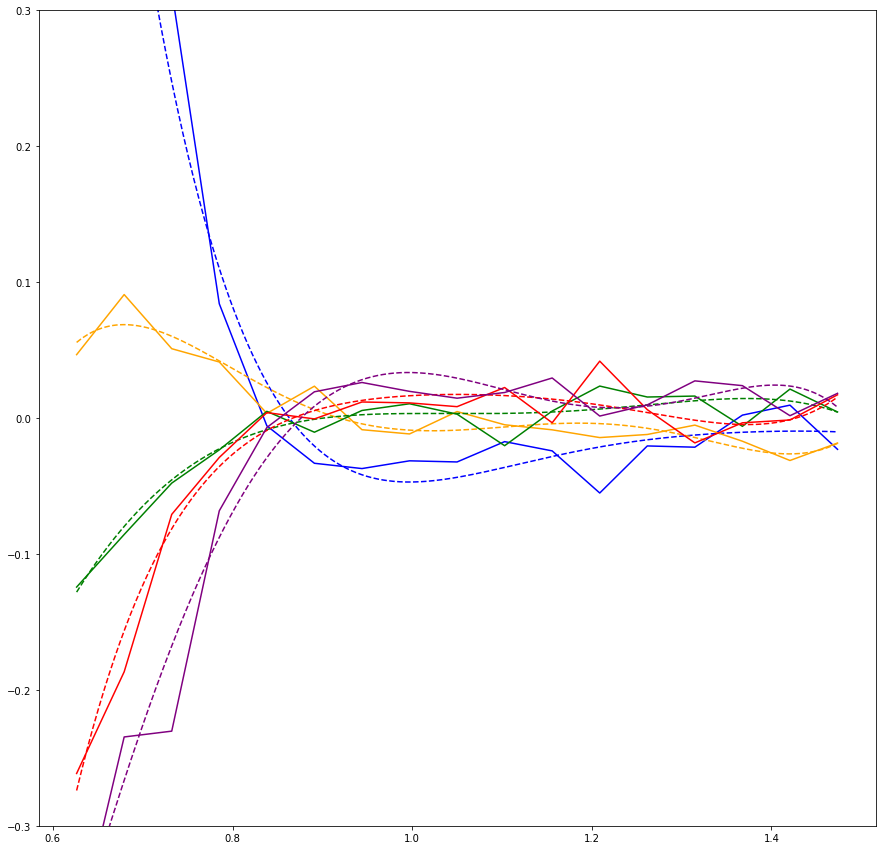

In [162]:
#https://machinelearningmastery.com/curve-fitting-with-python/
# fit a second degree polynomial to the economic data
from scipy.optimize import curve_fit
#plt.scatter(t['z'],t['dndz_bin0'])
#plt.ylim(-0.3,0.3)
fig = plt.figure(figsize=(15,15))
colors = ['b','orange','g','r','purple']
# define the true objective function
def objective(x, a, b, c, d, e, f):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f
for i, icol in enumerate([f'dndz_bin{i}' for i in range(5)]):
    # choose the input and output variables
    x, y = t['z'], t[icol]
    # curve fit
    popt, _ = curve_fit(objective, x, y)
    # summarize the parameter values
    a, b, c, d, e, f = popt
    print('y = %.5f * x + %.5f * x^2 + %.5f * x^3 + %.5f * x^4 + %.5f * x^5 + %.5f' % (a, b, c, d, e, f))
    # plot input vs output
    plt.plot(x, y, color=colors[i])
    #plt.show()
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    #print(x_line)
    # calculate the output for the range
    y_line = objective(x_line, a, b, c, d, e, f)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, '--', color=colors[i])
plt.ylim(-0.3,0.3)
plt.show()

y = -64.34225 * x + 81.38122 * x^2 + -45.23890 * x^3 + 9.34027 * x^4 + 18.80950
y = 5.69601 * x + -9.40698 * x^2 + 6.43059 * x^3 + -1.57430 * x^4 + -1.14914
y = 13.13630 * x + -17.50294 * x^2 + 10.29107 * x^3 + -2.24848 * x^4 + -3.67296
y = 20.95852 * x + -25.85009 * x^2 + 13.94251 * x^3 + -2.77975 * x^4 + -6.25070
y = 21.67894 * x + -25.05220 * x^2 + 12.62634 * x^3 + -2.34279 * x^4 + -6.88232


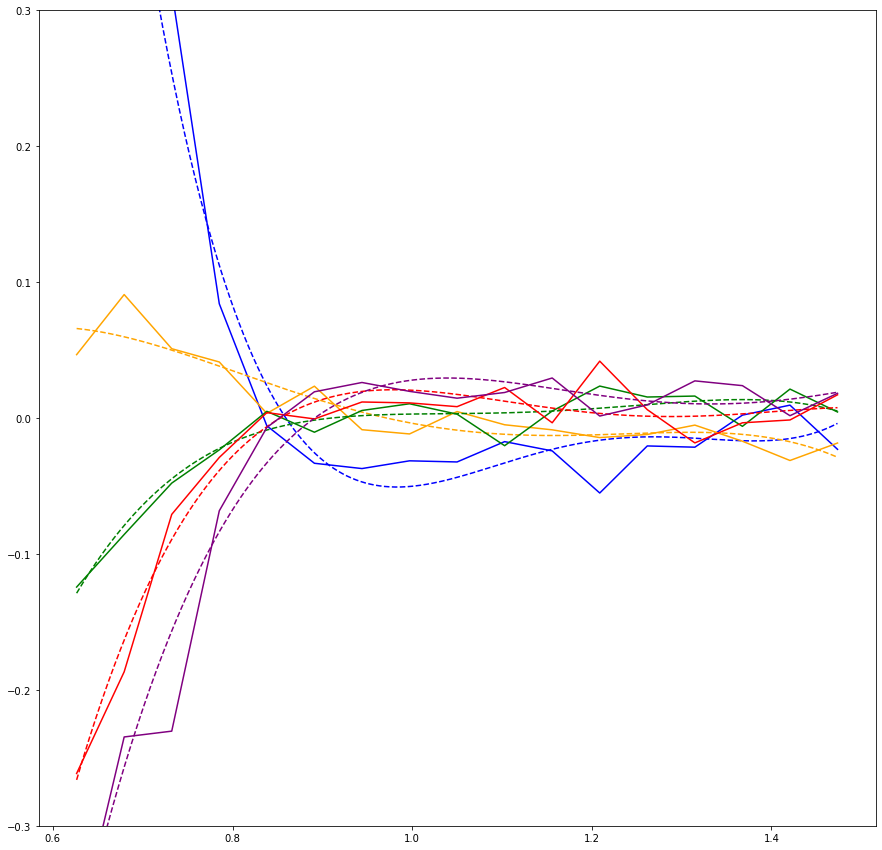

In [163]:
#https://machinelearningmastery.com/curve-fitting-with-python/
# fit a second degree polynomial to the economic data
from scipy.optimize import curve_fit
#plt.scatter(t['z'],t['dndz_bin0'])
#plt.ylim(-0.3,0.3)
fig = plt.figure(figsize=(15,15))
# define the true objective function
colors = ['b','orange','g','r','purple']
def objective(x, a, b, c, d, e):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + e#(e * x**5) + f
for i, icol in enumerate([f'dndz_bin{i}' for i in range(5)]):
    # choose the input and output variables
    x, y = t['z'], t[icol]
    # curve fit
    popt, _ = curve_fit(objective, x, y)
    # summarize the parameter values
    a, b, c, d, e = popt
    print('y = %.5f * x + %.5f * x^2 + %.5f * x^3 + %.5f * x^4 + %.5f' % (a, b, c, d, e))
    # plot input vs output
    plt.plot(x, y, colors[i])
    #plt.show()
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = np.arange(min(x), max(x), 0.001)
    #print(x_line)
    # calculate the output for the range
    y_line = objective(x_line, a, b, c, d, e)
    # create a line plot for the mapping function
    plt.plot(x_line, y_line, '--', color=colors[i])
plt.ylim(-0.3,0.3)
plt.show()